# **Project Title : Plant Disease Detection and Solution Recommendation**

imports libraries and packages

In [3]:

import os
import random
import sklearn
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')


Checking the number of all the images in the dataset


In [4]:
def count_images_in_folders(image_dir):
    total_images = 0
    directory_count = {}
    
    for root, dirs, files in os.walk(image_dir):          # Walk through the directory and count images
        count = 0
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.gif')):
                count += 1

        if count > 0:
            folder_name = os.path.basename(root)
            directory_count[folder_name] = count
        total_images += count
    return directory_count, total_images

image_dir = r'D:\KS\Plantdiseasedetectinon project\Crop__Diseases'
directory_count, total_images = count_images_in_folders(image_dir)
print("The number of images in each folder:")
for folder_name, count in directory_count.items():
    print(f"{folder_name} :      {count}")
print('.' * 30)
print(f"Total number of images: {total_images}")
display()



The number of images in each folder:
..............................
Total number of images: 0


In [4]:
#  Fix the number of images in each folder 
def process_folders(folder_path, target_size=1000,image_size = (224,224)):
    images = []
    labels = []
    folder_name = os.path.basename(folder_path)

    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.gif')): 
            img_path = os.path.join(folder_path, file_name)
            image = Image.open(img_path).convert('RGB')
            image = image.resize(image_size)
            images.append(np.array(image))
            labels.append(folder_name)

    while len(images) < target_size:
        random_image = random.choice(images)  
        images.append(random_image)
        labels.append(folder_name)
    return np.array(images[:target_size]), np.array(labels[:target_size])


def Data_Processing(image_dir, target_size=1000,image_size = (224,224)):
    all_images = []
    all_labels = []

    for folder_name in os.listdir(image_dir):
        folder_path = os.path.join(image_dir, folder_name)
        if os.path.isdir(folder_path):
            for subfolder_name in os.listdir(folder_path):
                subfolder_path = os.path.join(folder_path, subfolder_name)
                if os.path.isdir(subfolder_path):
                    images, labels = process_folders(subfolder_path, target_size,image_size = (224,224))
                    all_images.extend(images)
                    all_labels.extend(labels)
    return np.array(all_images), np.array(all_labels)


target_size = 1000
data_dir = r'D:\KS\Plantdiseasedetectinon project\Crop__Diseases'
images, labels = Data_Processing(data_dir, target_size,image_size = (224,224))
print(f"Processed {len(images)} images with labels.")
print(f"Images shape: {images.shape} Labels shape: {labels.shape}")

Processed 12000 images with labels.
Images shape: (12000, 224, 224, 3) Labels shape: (12000,)


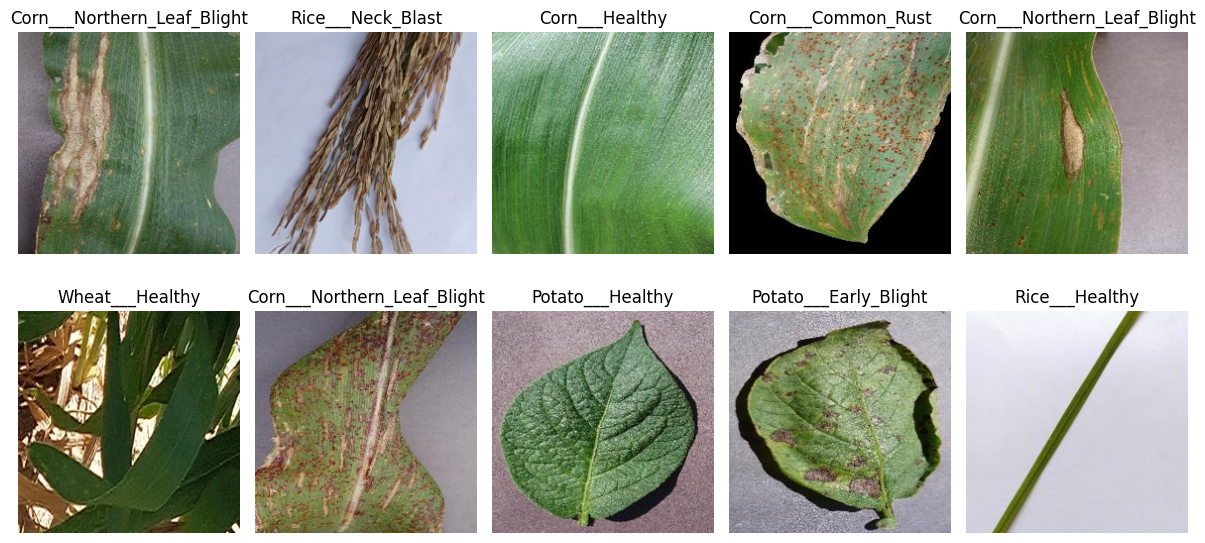

In [5]:
# Show some random images
random_indices = random.sample(range(len(images)), 10)
selected_images = [images[idx] for idx in random_indices]
selected_labels = [labels[idx] for idx in random_indices]


plt.figure(figsize=(12, 6))
for i, (image, label) in enumerate(zip(selected_images, selected_labels)):
    plt.subplot(2, 5, i + 1)  
    plt.imshow(image, cmap='gray') 
    plt.title(label)  
    plt.axis('off') 
plt.tight_layout() 
plt.show()

In [6]:
import os
from PIL import Image
import numpy as np

def save_images_and_labels(images, labels, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    label_folders = set(labels)
    for label in label_folders:
        label_folder = os.path.join(output_dir, label)
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)

    for idx, (image, label) in enumerate(zip(images, labels)):
        label_folder = os.path.join(output_dir, label)
        image_filename = f"{label}_{idx}.jpg"  
        image_path = os.path.join(label_folder, image_filename)
        pil_image = Image.fromarray(image)
        pil_image.save(image_path)
    print("Images and labels have been saved successfully.")

output_dir = r'D:\KS\Processed_Crop_Diseases'
save_images_and_labels(images, labels, output_dir)


Images and labels have been saved successfully.


In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import os

def dataload_and_augment(data_dir, batch_size=32, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Define image transformations
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    # Load the dataset using ImageFolder
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)

    # Calculate sizes for train, validation, and test datasets
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # Split dataset into train, validation, and test datasets
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Creating DataLoader for each dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=4)

    # Printing dataset sizes
    print(f"Training set: {len(train_loader.dataset)} images")
    print(f"Validation set: {len(val_loader.dataset)} images")
    print(f"Test set: {len(test_loader.dataset)} images")
    print()
    return train_loader, val_loader, test_loader,dataset


data_dir = r'D:\KS\Processed_Crop_Diseases'
train_loader, val_loader, test_loader= dataload_and_augment(data_dir)

# Check the first batch of the training data
images, labels = next(iter(train_loader))
print(f'Type of images: {type(images)}')
print(f'Shape of images: {images.shape}')


Training set: 9600 images
Validation set: 1200 images
Test set: 1200 images

Type of images: <class 'torch.Tensor'>
Shape of images: torch.Size([32, 3, 224, 224])


In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Adjusted AlexNet model with additional dropout and fewer parameters
def get_alexnet_model(num_classes):
    model = models.alexnet(pretrained=True)
    
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Modifing the final classifier layer for my task
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    model.classifier.add_module('dropout', nn.Dropout(0.5))  # Dropout after the 6th layer
    return model


num_classes = 12  # My number of classes 
model = get_alexnet_model(num_classes).to(device)

# Loss and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15):
    history = {
        "train_losses": [],
        "train_accuracies": [],
        "val_losses": [],
        "val_accuracies": []
    }
    
    best_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels).item()
        
        history["train_losses"].append(train_loss / len(train_loader))
        history["train_accuracies"].append(train_correct / len(train_loader.dataset))
        
        # Validation phase
        val_loss, val_correct = 0, 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels).item()

        history["val_losses"].append(val_loss / len(val_loader))
        history["val_accuracies"].append(val_correct / len(val_loader.dataset))
        
        # Printing progress after each epoch
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss:   {history['train_losses  '][-1]:.4f}      Train Accuracy:   {history['train_accuracies'][-1]:.4f},       Validation Loss:   {history['val_losses'][-1]:.4f},        Validation Accuracy: {history['val_accuracies'][-1]:.4f}")
        print("-" * 120)
        
        scheduler.step()
        if history["val_accuracies"][-1] > best_accuracy:      
            best_accuracy = history["val_accuracies"][-1] 
            torch.save(model.state_dict(), 'alexnet_model.pth')
    
    torch.save(history, 'training_history.pth')
    return history

history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15)


Using device: cpu
Epoch 1/15
Train Loss:   1.7984      Train Accuracy:   0.3960,       Validation Loss:   0.7772,        Validation Accuracy: 0.7333
------------------------------------------------------------------------------------------------------------------------
Epoch 2/15
Train Loss:   1.5902      Train Accuracy:   0.4495,       Validation Loss:   0.7674,        Validation Accuracy: 0.7433
------------------------------------------------------------------------------------------------------------------------
Epoch 3/15
Train Loss:   1.5507      Train Accuracy:   0.4589,       Validation Loss:   0.6355,        Validation Accuracy: 0.7833
------------------------------------------------------------------------------------------------------------------------
Epoch 4/15
Train Loss:   1.5347      Train Accuracy:   0.4621,       Validation Loss:   0.6176,        Validation Accuracy: 0.7950
-----------------------------------------------------------------------------------------------

In [13]:
import torch
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
from torchsummary import summary
import torch
torch.set_printoptions(profile="full")  


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  defining the AlexNet model
def get_alexnet_model(num_classes):
    model = models.alexnet(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    model.classifier.add_module('dropout', nn.Dropout(0.5))
    return model

# loading and summarizing the model
def load_and_summarize_model(model_file, num_classes, input_size=(3, 224, 224)):
    model = get_alexnet_model(num_classes).to(device)
    model.load_state_dict(torch.load(model_file, map_location=device))
    model.eval()
    summary(model, input_size=input_size)
    return summary

load_and_summarize_model('alexnet_model.pth',12,input_size= (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

<function torchsummary.torchsummary.summary(model, input_size, batch_size=-1, device='cuda')>

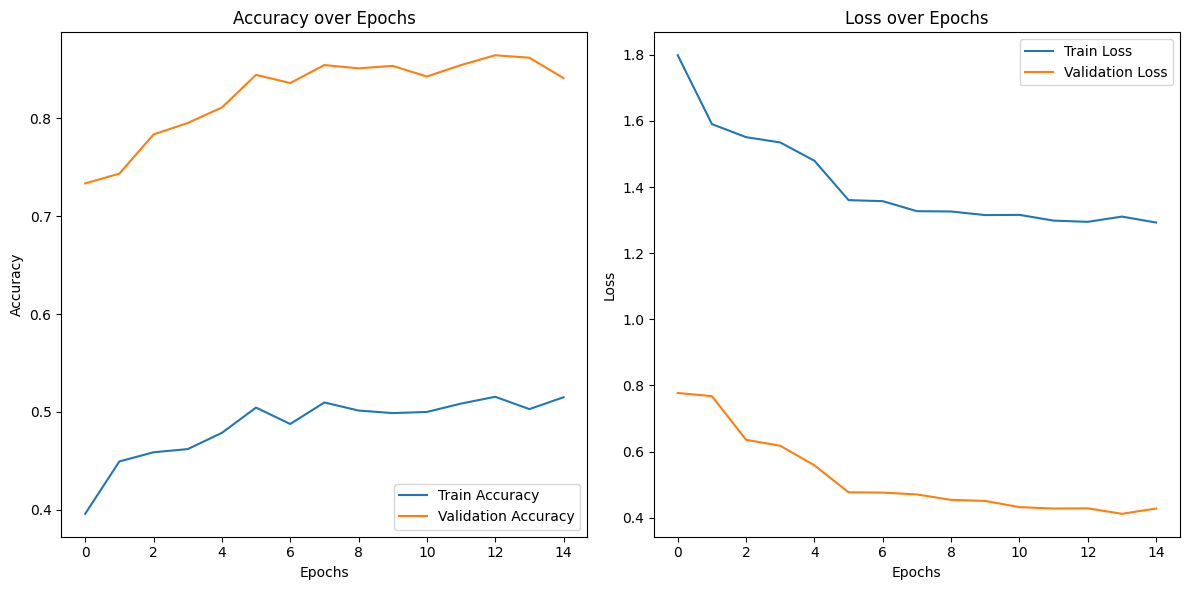

In [14]:
def plot_metrics(history):
    plt.figure(figsize=(12, 6))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history["train_accuracies"], label='Train Accuracy')
    plt.plot(history["val_accuracies"], label='Validation Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history["train_losses"], label='Train Loss')
    plt.plot(history["val_losses"], label='Validation Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

 # Replace with the number of classes in your dataset

# Load training history
history_file = 'training_history.pth'  # Replace with your saved training history path
history = torch.load(history_file)

# Plot the metrics
plot_metrics(history)

In [ ]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision import transforms
from PIL import Image

# Assuming the model definition is the same as before
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model architecture and state_dict
model = get_alexnet_model(12).to(device)  # Initialize model
saved_model_path = r'D:\KS\Plantdiseasedetectinon project\alexnet_model.pth'
model.load_state_dict(torch.load(saved_model_path, map_location=device))  # Loading model weights
model.eval()  # Setting the model to evaluation mode

# evaluate the model on the test dataset and save history for visualization
def evaluate_model(model, test_loader):
    model.eval()  # setting the  model is in evaluation mode
    test_correct = 0
    total_images = 0
    test_loss = 0
    criterion = torch.nn.CrossEntropyLoss()  # loss function for evaluation
    alexnet_history = {
        "test_losses": [],
        "test_accuracies": []
    }
    
    random_images = []
    random_labels = []
    random_preds = []

    with torch.no_grad():  # No gradients required for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to correct device
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            # Accumulate correct predictions and loss
            test_correct += torch.sum(preds == labels).item()
            total_images += labels.size(0)
            test_loss += loss.item()
            
            # Store random images and their predicted labels
            if len(random_images) < 5:  # Store only 5 random images for visualization
                indices = random.sample(range(images.size(0)), 5)  # Randomly select 5 indices
                for idx in indices:
                    random_images.append(images[idx].cpu())
                    random_labels.append(labels[idx].cpu())
                    random_preds.append(preds[idx].cpu())

        # Calculating test accuracy and average loss
        test_accuracy = test_correct / total_images
        average_test_loss = test_loss / len(test_loader)
        
        alexnet_history["test_losses"].append(average_test_loss)
        alexnet_history["test_accuracies"].append(test_accuracy)
    
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {average_test_loss:.4f}")
    return alexnet_history, random_images, random_labels, random_preds

alexnet_history, random_images, random_labels, random_preds = evaluate_model(model, test_loader)


Test Accuracy: 0.8650
Test Loss: 0.4270


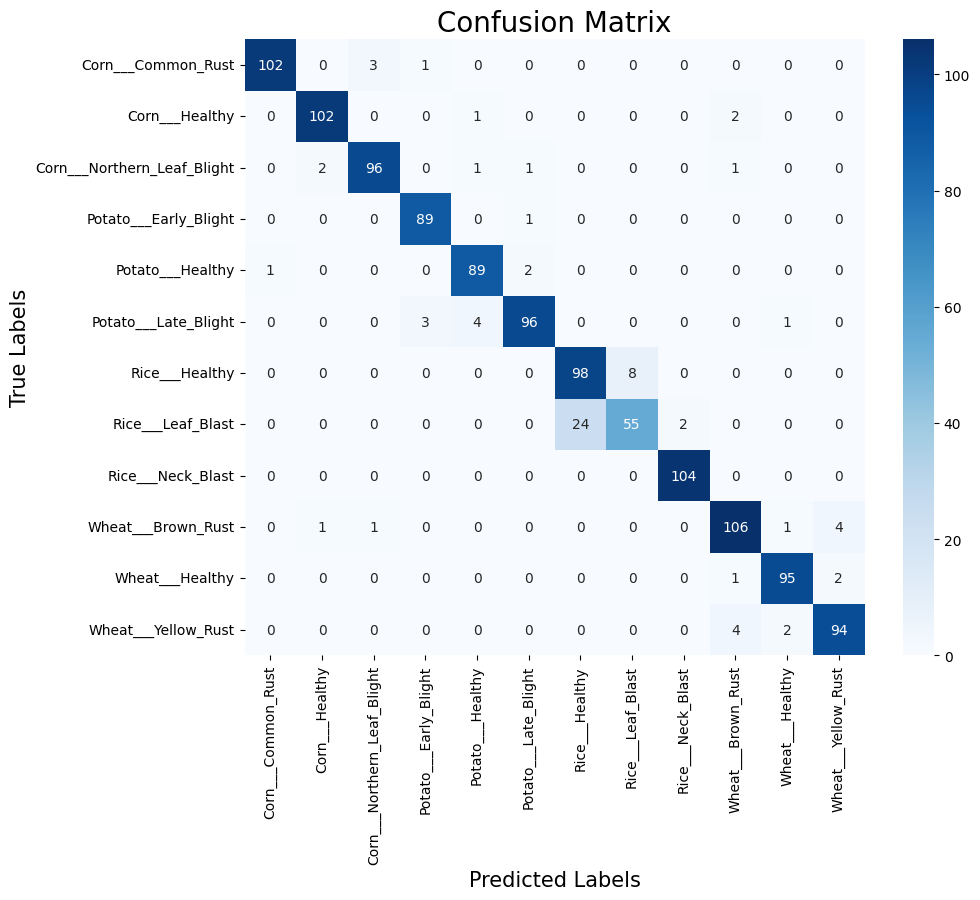

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns

def plot_confusion_matrix(model, test_loader):
    model.eval()  # evaluating the  model for evauation
    all_preds = []
    all_labels = []
    
    # Retrieve class names dynamically from the dataset
    class_names = test_loader.dataset.dataset.classes

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    
    # Ploting the confusion matrix using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels',fontsize = 15)
    plt.ylabel('True Labels',fontsize= 15)
    plt.title('Confusion Matrix',fontsize= 20)
    plt.show()

plot_confusion_matrix(model, test_loader)


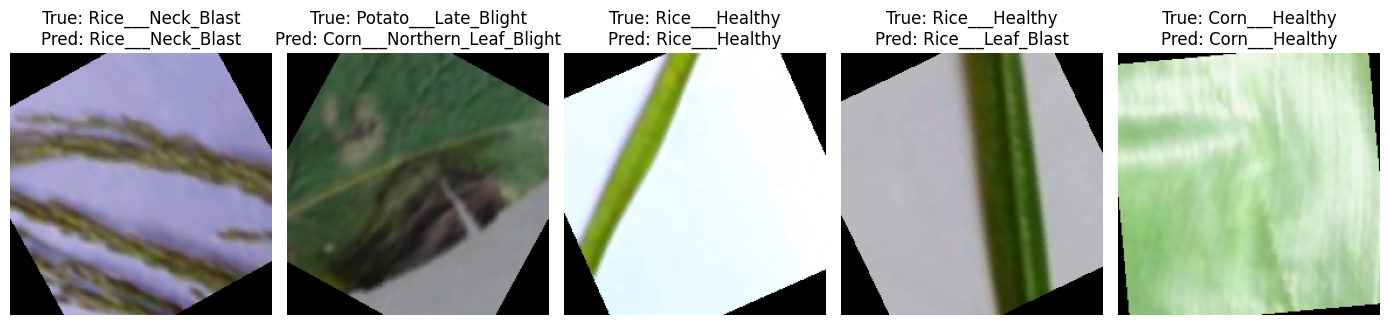

In [18]:
import matplotlib.pyplot as plt
import torch

def denormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def plot_random_images(images, labels, preds, test_loader, mean, std):
    class_names = test_loader.dataset.dataset.classes
    denorm_images = [denormalize(img, mean, std).permute(1, 2, 0).cpu().numpy() for img in images]
    plt.figure(figsize=(14, 8))
    for i in range(len(denorm_images)):
        plt.subplot(1, len(denorm_images), i + 1)
        plt.imshow(denorm_images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
#  getting the ranodm samples for ploting 
def get_random_samples(test_loader, num_samples=5):
    dataset = test_loader.dataset
    indices = torch.randint(0, len(dataset), (num_samples,))
    images, labels = zip(*[dataset[idx] for idx in indices])
    return images, labels

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
random_images, random_labels = get_random_samples(test_loader, num_samples=5)

model.eval()
random_preds = []
with torch.no_grad():
    for img in random_images:
        img = img.unsqueeze(0).to(device)
        output = model(img)
        _, pred = torch.max(output, 1)
        random_preds.append(pred.item())

plot_random_images(random_images, random_labels, random_preds, test_loader, mean, std)


In [25]:
def get_resnet50_model(num_classes): # defining the model
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    for param in model.layer4[-1].parameters():
        param.requires_grad = True

    # Modify the final fully connected layer
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes))
    return model


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms  
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#  getting the model 
def get_resnet50_model(num_classes):
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    for param in model.layer4[-1].parameters():
        param.requires_grad = True

    # Modifing the final fully connected layer
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes))
    return model


num_classes = len(dataset.classes)  
model = get_resnet50_model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15):
    history = {
        "train_losses": [],
        "train_accuracies": [],
        "val_losses": [],
        "val_accuracies": []
    }
    # Training Phase
    best_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels).item()
        history["train_losses"].append(train_loss / len(train_loader))
        history["train_accuracies"].append(train_correct / len(train_loader.dataset))
        
        # Validation phase
        val_loss, val_correct = 0, 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels).item()

        # Calculating evaluatio 1 
        history["val_losses"].append(val_loss / len(val_loader))
        history["val_accuracies"].append(val_correct / len(val_loader.dataset))

        # Printing progress after each epoch
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss:   {history['train_losses'][-1]:.4f}      Train Accuracy:   {history['train_accuracies'][-1]:.4f},       Validation Loss:   {history['val_losses'][-1]:.4f},        Validation Accuracy: {history['val_accuracies'][-1]:.4f}")
        print("-" * 130)

        scheduler.step()
        if history["val_accuracies"][-1] > best_accuracy:      
            best_accuracy = history["val_accuracies"][-1] 
            torch.save(model.state_dict(), 'improved_resnet50_model.pth')
    torch.save(history, 'training_history_15.pth')
    return history
 
# Train the model and save history
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15)


Using device: cpu
Epoch 1/15
Train Loss:   0.7489      Train Accuracy:   0.7172,       Validation Loss:   0.3341,        Validation Accuracy: 0.8617
----------------------------------------------------------------------------------------------------------------------------------
Epoch 2/15
Train Loss:   0.4067      Train Accuracy:   0.8407,       Validation Loss:   0.3122,        Validation Accuracy: 0.8808
----------------------------------------------------------------------------------------------------------------------------------
Epoch 3/15
Train Loss:   0.3460      Train Accuracy:   0.8670,       Validation Loss:   0.2614,        Validation Accuracy: 0.8958
----------------------------------------------------------------------------------------------------------------------------------
Epoch 4/15
Train Loss:   0.3272      Train Accuracy:   0.8744,       Validation Loss:   0.2417,        Validation Accuracy: 0.9025
-----------------------------------------------------------------

In [23]:
import torch
from torchvision import models
import torch.nn as nn
from torchsummary import summary

def load_and_summarize_model(model_file, num_classes, input_size=(3, 224, 224)):
    def get_resnet50_model(num_classes):
        model = models.resnet50(pretrained=False)
        for param in model.parameters():
            param.requires_grad = False
        for param in model.layer4[-1].parameters():
            param.requires_grad = True
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        return model

    model = get_resnet50_model(num_classes)
    model.load_state_dict(torch.load(model_file))
    model.eval()
    summary(model, input_size=input_size)

    return model

model = load_and_summarize_model('improved_resnet50_model.pth', num_classes=12)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

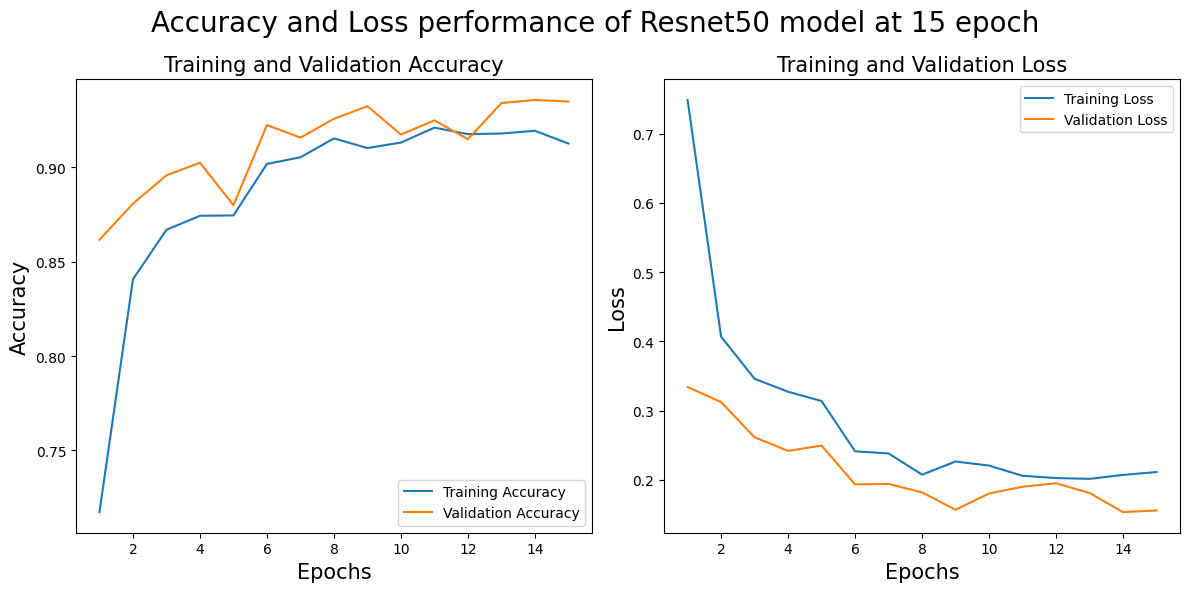

In [20]:
import torch
import matplotlib.pyplot as plt

def plot_training_history(history_file):

    history = torch.load(history_file)
    epochs = range(1, len(history['train_accuracies']) + 1)
    training_accuracy = history['train_accuracies']
    validation_accuracy = history['val_accuracies']
    training_loss = history['train_losses']
    validation_loss = history['val_losses']

    plt.figure(figsize=(12, 6))
    plt.suptitle('Accuracy and Loss performance of Resnet50 model at 15 epoch',fontsize = 20)
    plt.subplot(1, 2, 1)  
    plt.plot(epochs, training_accuracy, label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy',fontsize = 15)
    plt.xlabel('Epochs',fontsize= 15)
    plt.ylabel('Accuracy',fontsize = 15)
    plt.legend()

    plt.subplot(1, 2, 2)  
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.title('Training and Validation Loss',fontsize= 15)
    plt.xlabel('Epochs',fontsize = 15)
    plt.ylabel('Loss',fontsize = 15)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history('training_history_15.pth')


In [31]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision import transforms
from PIL import Image

# Assuming the model definition is the same as before
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model architecture and state_dict
model = get_resnet50_model(12).to(device)  # Initialize model
saved_model_path = r'D:\KS\Plantdiseasedetectinon project\improved_resnet50_model.pth'
model.load_state_dict(torch.load(saved_model_path, map_location=device))  # Loading model weights
model.eval()  # Set the model to evaluation mode

#  evaluating the model on the test dataset
def evaluate_model(model, test_loader):
    model.eval()  #  evaluation mode
    test_correct = 0
    total_images = 0
    test_loss = 0
    criterion = torch.nn.CrossEntropyLoss()  # Define loss function for evaluation
    history = {
        "test_losses": [],
        "test_accuracies": []
    }
    
    # Store random images and predictions for visualization
    random_images = []
    random_labels = []
    random_preds = []

    with torch.no_grad():  # No gradients required for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to correct device
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            # accumulating the  correct predictions and loss
            test_correct += torch.sum(preds == labels).item()
            total_images += labels.size(0)
            test_loss += loss.item()
            
            # Storingrandom images and their predicted labels
            if len(random_images) < 5:
                indices = random.sample(range(images.size(0)), 5)  
                for idx in indices:
                    random_images.append(images[idx].cpu())
                    random_labels.append(labels[idx].cpu())
                    random_preds.append(preds[idx].cpu())

        # Calculate test accuracy and average loss
        test_accuracy = test_correct / total_images
        average_test_loss = test_loss / len(test_loader)
        
        history["test_losses"].append(average_test_loss)
        history["test_accuracies"].append(test_accuracy)
    
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {average_test_loss:.4f}")

    return history, random_images, random_labels, random_preds
history, random_images, random_labels, random_preds = evaluate_model(model, test_loader)



Test Accuracy: 0.9492
Test Loss: 0.1324


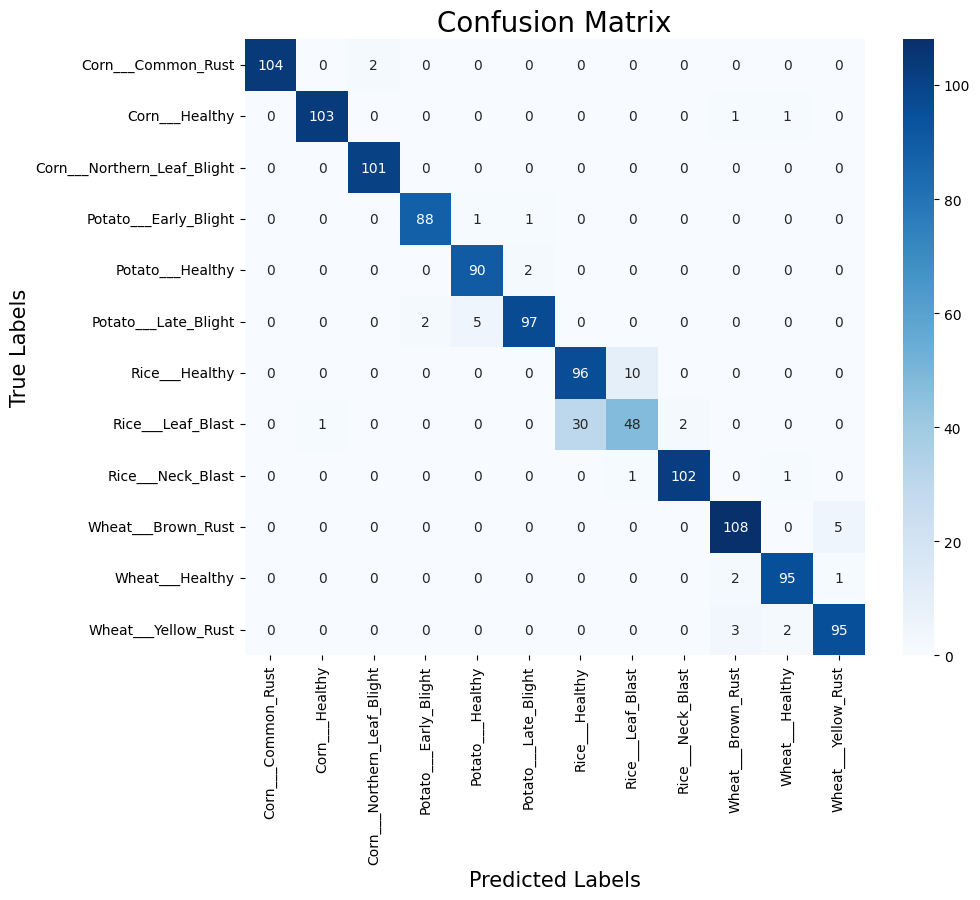

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns

def plot_confusion_matrix(model, test_loader):
    model.eval()  # Ensure the model is in evaluation mode
    all_preds = []
    all_labels = []
    
    # Retrieve class names dynamically from the dataset
    class_names = test_loader.dataset.dataset.classes

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculating the confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    
    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels',fontsize = 15)
    plt.ylabel('True Labels',fontsize= 15)
    plt.title('Confusion Matrix',fontsize= 20)
    plt.show()

plot_confusion_matrix(model, test_loader)


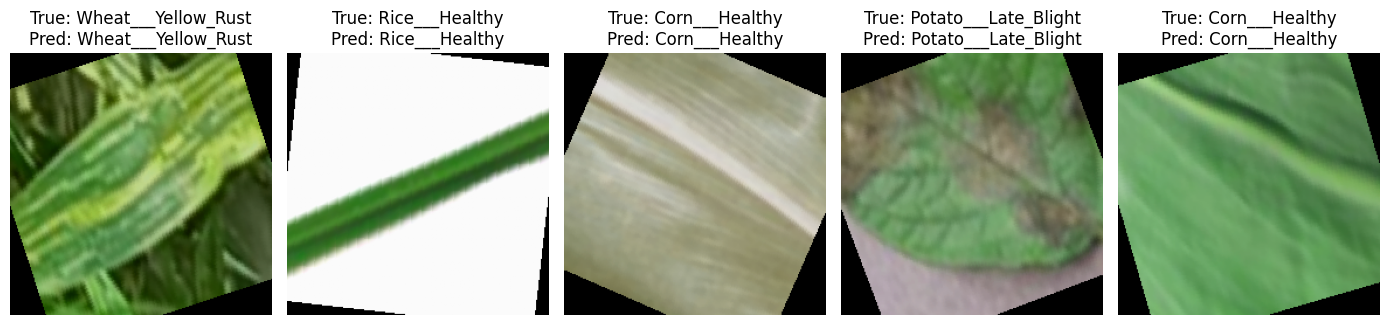

In [22]:
import matplotlib.pyplot as plt
import torch

def denormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def plot_random_images(images, labels, preds, test_loader, mean, std):
    class_names = test_loader.dataset.dataset.classes
    denorm_images = [denormalize(img, mean, std).permute(1, 2, 0).cpu().numpy() for img in images]
    plt.figure(figsize=(14, 8))
    for i in range(len(denorm_images)):
        plt.subplot(1, len(denorm_images), i + 1)
        plt.imshow(denorm_images[i])
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def get_random_samples(test_loader, num_samples=5):
    dataset = test_loader.dataset
    indices = torch.randint(0, len(dataset), (num_samples,))
    images, labels = zip(*[dataset[idx] for idx in indices])
    return images, labels

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
random_images, random_labels = get_random_samples(test_loader, num_samples=5)

model.eval()
random_preds = []
with torch.no_grad():
    for img in random_images:
        img = img.unsqueeze(0).to(device)
        output = model(img)
        _, pred = torch.max(output, 1)
        random_preds.append(pred.item())

plot_random_images(random_images, random_labels, random_preds, test_loader, mean, std)
